# 流路の可視化


In [154]:
import struct
import numpy as np
import os
import re

In [155]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [156]:
from src import OpenFile

In [157]:
echo %PATH%

c:\Users\yucch\00_workstation\Valid-Error-Tpfit\venv\Scripts;C:\Users\yucch\00_workstation\Valid-Error-Tpfit\venv\Scripts;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8\bin;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8\libnvvp;C:\Users\yucch\anaconda3;C:\Users\yucch\anaconda3\Scripts;C:\Users\yucch\anaconda3\Library\bin;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0\;C:\Windows\System32\OpenSSH\;C:\MinGW\bin;C:\Program Files (x86)\QuickTime\QTSystem\;C:\Users\yucch\anaconda3\python.exe;C:\Program Files\nodejs\;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR;C:\Program Files\dotnet\;C:\Program Files\Git\cmd;C:\Program Files\MATLAB\R2022b\bin;C:\Program Files (x86)\Windows Kits\10\Windows Performance Toolkit\;C:\Program Files\NVIDIA Corporation\Nsight Compute 2022.3.0\;C:\Users\yucch\anaconda3\envs\ultra\Lib\site-packages;;C:\Program Files(x86)\GnuWin32\bin;C

In [158]:
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d
def interpolate_grid(x, y, z, u, new_dx):

    interp = RegularGridInterpolator((x, y, z), u) # method = "linear"
    xg,yg,zg=np.meshgrid(x,y,z,indexing='ij')
    new_shape = (int((xg[-1, 0, 0] - xg[0, 0, 0]) / new_dx) + 1,
                 int((yg[0, -1, 0] - yg[0, 0, 0]) / new_dx) + 1,
                 int((zg[0, 0, -1] - zg[0, 0, 0]) / new_dx) + 1)

    new_x, new_y, new_z = np.meshgrid(np.linspace(xg[0, 0, 0], xg[-1, 0, 0], new_shape[0]),
                                       np.linspace(yg[0, 0, 0], yg[0, -1, 0], new_shape[1]),
                                       np.linspace(zg[0, 0, 0], zg[0, 0, -1], new_shape[2]), indexing='ij')

    data2=interp((new_x,new_y,new_z))
    return new_x, new_y, new_z, data2


In [159]:
import struct
import numpy as np
import os
import re

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid

In [160]:
#入力データのディレクトリ
data_path=r"input"
# 現在のカレントディレクトリを取得します
directory_path = os.getcwd()
directory_path

'c:\\Users\\yucch\\00_workstation\\Valid-Error-Tpfit\\notebooks'

In [161]:
t=OpenFile.make_folder("output",directory_path)
print("output_path:", t)
#shared_name,data_files=OpenFile.get_shared_name(data_path)
shared_name="case60g02out"

shared_name

Folder 'output' already exists in 'c:\Users\yucch\00_workstation\Valid-Error-Tpfit\notebooks'.
output_path: c:\Users\yucch\00_workstation\Valid-Error-Tpfit\notebooks\output


'case60g02out'

In [162]:
struct_name=shared_name+"S_00000"
struct_path=os.path.join(data_path,struct_name)
struct_path

'input\\case60g02outS_00000'

In [163]:
filename_s=f"input\{shared_name}S_00000"

In [164]:
data_s_origin=np.array(OpenFile.get_data_from_binary(filename_s)) 
data_s_origin

array([0., 0., 0., ..., 0., 0., 0.])

In [165]:
#座標データ抽出
points = []
for d in ["X","Y","Z"]:

    data_path_ndim=f"{data_path}/{shared_name}{d}_00000"
    #ファイル読み込み
    with open(data_path_ndim, 'rb') as file:
        # バイナリデータを読み取り
        binary_data_ndim = file.read()
  
    # バイナリデータを文字列に変換（適切なエンコーディングを指定）
    text_data = binary_data_ndim.decode('utf-8')  # 例としてUTF-8を使用

    # 正規表現を使って「X-Axis Coordinate」に関連するデータを抽出
    pattern_d= re.compile(r'{}-Axis Coordinate\n([\s\S]*?)(?=\n[A-Z]|$)'.format(d))
    match_d = pattern_d.search(text_data)
    if match_d:
        coordinates = match_d.group(1).strip().split()
        # 数値を浮動小数点数に変換
        coordinates = np.array([float(coord) for coord in coordinates] )
        points.append(coordinates)


In [166]:
x_points=points[0][1:-1]
y_points=points[1][1:-1]
z_points=points[2][1:-1]
x_points.shape,y_points.shape,z_points.shape

((60,), (60,), (472,))

In [167]:
x_crop=points[0][[0,-1]]
y_crop=points[1][[0,-1]]
z_crop=points[2][[0,-1]]
x_crop,y_crop,z_crop

(array([-0.001525,  0.001525]),
 array([-0.001525,  0.001525]),
 array([-2.5000e-05,  2.0025e-02]))

In [168]:
data_shape=(points[0].shape[0],points[1].shape[0],points[2].shape[0])
data_shape

(62, 62, 474)

In [169]:
data_s = data_s_origin.reshape(data_shape, order="F")[1:-1,1:-1, 1:-1]
data_s.shape

(60, 60, 472)

In [170]:
plot_points=[ (0,1,2), (30,30,10), (30,30,400)]
plot_c = [ 1,5, 300]


In [171]:
x,y,z = np.meshgrid(points[0],points[1],points[2], indexing='ij')
print(z.shape)
for i, index in enumerate(plot_points):
    print(index)
    print(plot_c[i],(x[index],y[index],z[index]))

(62, 62, 474)
(0, 1, 2)
1 (-0.001525, -0.001475, 7.5e-05)
(30, 30, 10)
5 (-2.5e-05, -2.5e-05, 0.000475)
(30, 30, 400)
300 (-2.5e-05, -2.5e-05, 0.016375)


In [172]:
array_x=np.array([x[p] for p in plot_points])
array_y=np.array([y[p] for p in plot_points])
array_z=np.array([z[p] for p in plot_points])
array_c=np.array(plot_c)
array_x,array_y,array_z

(array([-1.525e-03, -2.500e-05, -2.500e-05]),
 array([-1.475e-03, -2.500e-05, -2.500e-05]),
 array([7.5000e-05, 4.7500e-04, 1.6375e-02]))

In [173]:
# 流路の描画
# 座標点のプロット

# 座標点の可視化

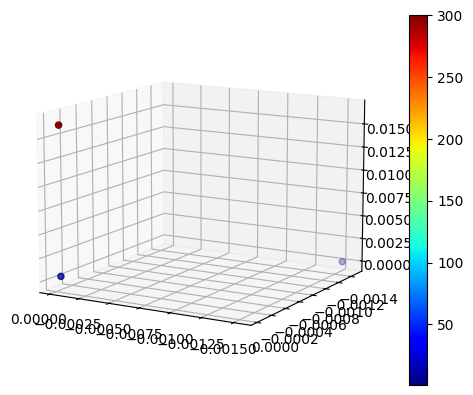

In [174]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx

colormap = plt.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=0, vmax=np.max(array_c))

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')


ax_scatter_obj = ax.scatter(array_x, array_y, array_z, s = 20, c = array_c, cmap = colormap)
fig.colorbar(ax_scatter_obj)

# x_axis = [0, 1, 2, 3, 4, 5]
# y_axis = [0, 1, 2, 3]
# z_axis = [0, 1, 2]
# ax.set_xticks(x_axis)
# ax.set_yticks(y_axis)
# ax.set_zticks(z_axis)

ax.view_init(elev = 12, azim = 120)


plt.show()

# 流路の描画

In [175]:
# 格子幅そろえる処理
delta=0.1*10**-3
X,Y,Z, data_s=interpolate_grid(x_points,y_points,z_points,data_s,delta)
data_shape_after=data_F.shape
data_shape_after

(30, 30, 200)

In [176]:
verts, faces, normals, values = measure.marching_cubes(data_s, 0.5,spacing=(delta,delta,delta))
verts.shape,faces.shape

((13620, 3), (27184, 3))

In [177]:
#等値面の原点地点にoffsetを掛ける
cube_offset=np.array([[np.min(x_points),np.min(y_points),np.min(z_points)]])
verts+cube_offset

array([[-0.001425  , -0.000375  ,  0.003825  ],
       [-0.001375  , -0.00045404,  0.003825  ],
       [-0.001375  , -0.000375  ,  0.003775  ],
       ...,
       [ 0.001375  ,  0.000325  ,  0.012225  ],
       [ 0.001375  ,  0.000325  ,  0.012325  ],
       [ 0.001375  ,  0.000325  ,  0.012425  ]])

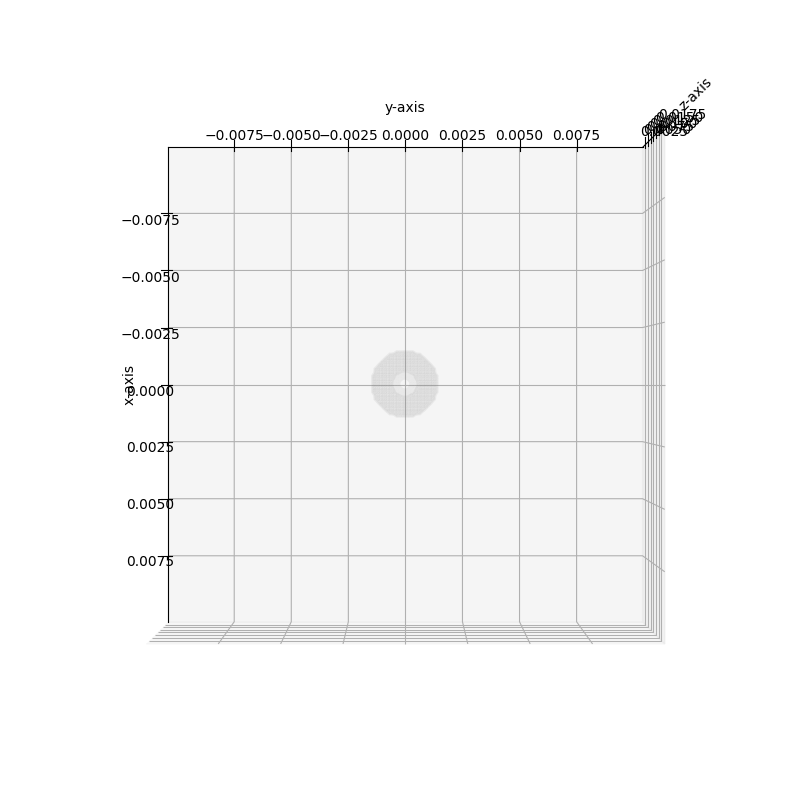

In [178]:
# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces]+cube_offset,alpha=0.1, facecolors='gray')
# mesh.set_edgecolor('')
# https://qiita.com/taiko1/items/23379266c1aaa2e67acc

ax.add_collection3d(mesh)

ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")

max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() * 0.5

#軸スケール一定
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# 真正面から見るための視点を設定する
ax.view_init(elev=90, azim=0)  # elevは仰角（上下の角度）、azimは方位角（左右の角度）
# plt.tight_layout()
plt.show()

# 座標および流路の可視化

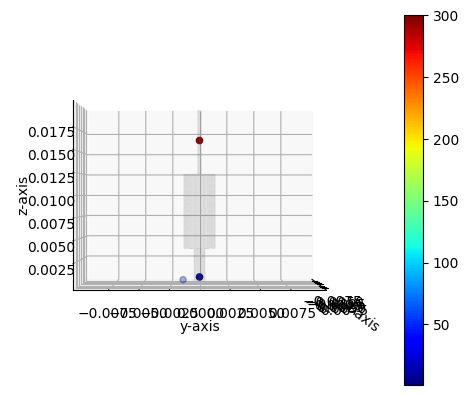

In [179]:
colormap = plt.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=0, vmax=np.max(array_c))

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')


ax_scatter_obj = ax.scatter(array_x, array_y, array_z, s = 20, c = array_c, cmap = colormap)
fig.colorbar(ax_scatter_obj)



# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces]+cube_offset,alpha=0.1, facecolors='gray')
# mesh.set_edgecolor('')
# https://qiita.com/taiko1/items/23379266c1aaa2e67acc

ax.add_collection3d(mesh)

ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")

max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() * 0.5

#軸スケール一定
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# 真正面から見るための視点を設定する
ax.view_init(elev = 0, azim = 0)# elevは仰角（上下の角度）、azimは方位角（左右の角度）


plt.show()